# Exercise 6 - EKF Localization

In this assignment you need to implement an EKF algorithm for localizing a robot in a given landmark map. 
The data for this exercise is recorded on a differential drive robot equipped with a sensor able to detect the distance and the angle of landmarks (e.g., beacons). The figure below visualizes the landmark map and the actual trajectory (ground truth) taken by the robot.

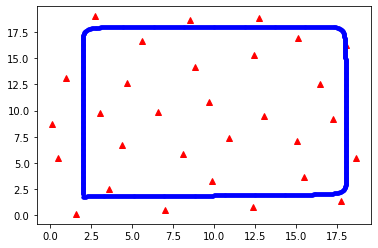

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from ex6 import *
%matplotlib inline

# read dataset
data = pickle.load(open("dataset_2d_landmarks.p", "rb"))

# get landmark coordinates 
M = data['M']

# get ground truth trajectory
gt_traj = data['gt']

# show map
plt.figure(1)
plt.plot(M[:,0], M[:,1], '^r')

# show ground truth trajectory
for i in range(0,len(gt_traj)):
    plt.plot(gt_traj[i][0],gt_traj[i][1], '.b')


The following data is provided in `data`:

- *M* is the map of the environment where the robot must localize
- *odom* is the noisy odometry readings observed by the robot during navigation in the form: $\hat{x}_t,\hat{y}_t, \hat{\theta}_t$ in the odometry frame
- *gt* is the ground truth trajectory (poses in the map frame), you may want to use it for checking your results
- *z* are the sensor measurements

Each measurement $z_t$ contains a set of observed landmarks $[\rho_i; \phi_i; id_i]$, where $\rho_i$ is the measured distance, $\phi_i$ is the measured angle, and $id_i$ is the id of the landmark.

You can access the `data` as follows:

In [2]:
# get odomety at timestamp 10
odom_10 = data['odom'][10]
print("Odom at step 10 is: \n",odom_10)

# get observation at timestamp 10
z_10 = data['z'][10]
print("Observation at step 10 is: \n",z_10)

Odom at step 10 is: 
 [ 0.3449921   0.00058428 -0.02110238]
Observation at step 10 is: 
 [[ 2.1793557   1.27533718  3.5604415 ]
 [ 2.92652148 -1.4372858   0.4519207 ]
 [ 4.         11.         14.        ]]


## Exploring the feature Map 
Just to know the shape and info provided  to develop correction step.

In [3]:
M = data["M"]
print(M.shape)
#view the landmark with id 1
print(M[1][0])

print(len(data["z"]))

(30, 2)
9.846508527466666
2092


## 6.1 Prediction [3.0]

The `ekf_predict` function computes a prediction about the robot's pose after moving by using the odometry motion model.

It takes as input:

- the current belief about the pose of the robot represented as a Gaussian distribution $\mathcal{N}(\mu_t,\Sigma_t)$ 
- the odometry readings $u_t$

The output is a prediction about the robot's pose $\mathcal{N}(\overline{\mu}_{t+1},\overline{\Sigma}_{t+1})$.

You can use your implementation of the `inverse_motion_model` function from Exercise 3 to compute the $u_t = [\delta_{rot1}, \delta_{trans}, \delta_{rot2}]$  from the odometry information.

Implement the `ekf_predict` function and verify that it is correct for some test input. 

In [4]:
x_init = np.array([1, 0 , 0]).reshape(3,1)
u = [[0,0,0],
    [1, 1, 0]]
P = np.eye(3,3)

x_pred,P_pred = ekf_predict(x_init,P,u)
print(x_pred,'\n',P_pred)

[[2.]
 [1.]
 [0.]] 
 [[ 2. -1. -1.]
 [-1.  2.  1.]
 [-1.  1.  1.]]


## 6.2 Correction [3.0]

The `ekf_correct` implements the correction step of the EKF that corrects the prediction according to the sensor measurements.

It takes as input:

- the current prediction about the pose of the robot represented as a Gaussian distribution $\mathcal{N}(\overline{\mu}_{t+1},\overline{\Sigma}_{t+1})$
- the sensor measurements $z_t$

The output is new belief about the robot's pose $\mathcal{N}({\mu}_{t+1},{\Sigma}_{t+1})$.

Implement the `ekf_correct` function and verify that it is correct for some test input

In [5]:
# 3x3 process noise
sigma_x = 0.25  # [m]
sigma_y = 0.25  # [m]
sigma_theta = np.deg2rad(10)  # [rad]
R = np.diag(np.array([sigma_x, sigma_y, sigma_theta])**2)

# 2x2 observation noise
sigma_r = 0.1  # [m]
sigma_phi = np.deg2rad(5)  # [rad]
Q = np.diag(np.array([sigma_r, sigma_phi])**2)

x = np.array([2, 2, np.pi/2]).T 
P = np.array([[1, 0, 0],[0, 1, 0], [0, 0, np.pi/3]])


for i in range(1,100):
    u = [data['odom'][i-1],data['odom'][i]]
    z = data['z'][i]
    x_pred,P_pred = ekf_predict(x,P,u,R)
    x,P = ekf_correct(x_pred, P_pred,z,data['M'],Q)
print(x,P)
print(data["gt"][100])

[[2.0040227]
 [4.9373632]
 [1.5636316]] [[ 2.75648868e-04  2.67331217e-05 -1.60102224e-05]
 [ 2.67331217e-05  2.15708967e-03  6.52565542e-05]
 [-1.60102224e-05  6.52565542e-05  1.25167499e-03]]
[2.         5.03       1.57079633]


## 6.3 Localization [3.0]

Once you complete all the above functions, implement the main procedure of EKF localization `ekf_localization` which recursively estimates the pose of the robot using the odometry data and the sensor measurements.

Assume the initial belief at time $t=0$ is:

- $\mu = [2, 2, \pi/2]'$
- $
\Sigma = \left(\begin{array}{cc} 
1 & 0 & 0\\
0 & 1 & 0 \\
0 & 0 & \pi/3
\end{array}\right)
$ 
            
The process noise $R$ and measurement noise $Q$ are defined as:
- $R = \left(\begin{array}{cc} 
\sigma_x^2 & 0 & 0 \\
0 & \sigma_y^2 & 0 \\
0 & 0 &  \sigma_{theta}^2
\end{array}\right)
$

with $\sigma_x = 0.25$ meters, $\sigma_y = 0.25$ meters and $\sigma_theta = 10$ degrees. 
 
- $Q = 
\left(\begin{array}{cc} 
\sigma_r^2 & 0 \\
0 & \sigma_{phi}^2 
\end{array}\right)
$

with $\sigma_r = 0.10$ meters, $\sigma_{phi} = 5$ degrees. 

Plot the belief about the position of the robot after the sequence of odometry readings and sensor measurements provided in `data` by using the `plot_state` function.

(3,)


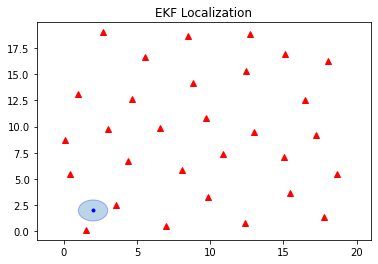

In [6]:
# 3x3 process noise
sigma_x = 0.25  # [m]
sigma_y = 0.25  # [m]
sigma_theta = np.deg2rad(10)  # [rad]
R = np.diag(np.array([sigma_x, sigma_y, sigma_theta])**2)

# 2x2 observation noise
sigma_r = 0.1  # [m]
sigma_phi = np.deg2rad(5)  # [rad]
Q = np.diag(np.array([sigma_r, sigma_phi])**2)

# initial state
mu = np.array([2, 2, np.pi/2]).T 
print(mu.shape)
S = np.array([[1, 0, 0],[0, 1, 0], [0, 0, np.pi/3]])

# visualize
plt.figure()
plot_state(mu, S, M)


In [7]:
est_traj =[]
for i in range(1,len(data['odom'])):
    est_traj.append([mu[0,0],mu[1,0]])   
    u = [data['odom'][i-1],data['odom'][i]]
    z = data['z'][i]
    mu_pred,S_pred = ekf_predict(mu,S,u,R)
    mu,S = ekf_correct(mu_pred, S_pred,z,M,Q)
print(mu)
print(data['gt'][2091])


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
print(len(data["gt"]))
print(len(est_traj))

In [ ]:
# show map
plt.figure(1)
plt.plot(M[:,0], M[:,1], '^r')

# show ground truth trajectory
for i in range(0,len(est_traj)):
    plt.plot(est_traj[i][0],est_traj[i][1], '.b')